# UB DataScience: Complex networks
### David Solans & Gerard Martinez

In [1]:

import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
from networkx.algorithms import community
import collections
import numpy as np
import pickle
import operator
import folium
from scipy.optimize import curve_fit

plt.style.use('seaborn')

%matplotlib inline

## Loading data

In [2]:
G_transport = nx.read_edgelist("barcelona_transport.edgelist", create_using = nx.Graph(), nodetype = int)
G_bus = nx.read_edgelist("barcelona_bus.edgelist", create_using = nx.Graph(), nodetype = int)
G_metro = nx.read_edgelist("barcelona_metro.edgelist", create_using = nx.Graph(), nodetype = int)

In [3]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
bus_stations_properties = load_obj("bus_stations_properties")

## Week 6 - 

The idea of the notebook is to follow step by step chapter 16 of Introduction to the Modeling and Analysis of Complex Systems by Hiroky Sayama. This chapter tittled Dynamical Networks I: Modeling expplains the main three classes of dynamical network models which are:

- ** Models for “dynamics on networks"**: These models are the most natural extension of traditional dynamical systems models. They consider how the states of components, or nodes, change over time through their interactions with other nodes that are connected to them.

- ** Models for “dynamics of networks”**: These are the models that consider dynamical changes of network topology itself over time, for various purposes: to understand mecha- nisms that bring particular network topologies, to evaluate robustness and vulnerability of networks, to design procedures for improving certain properties of networks, etc.

- ** Models for “adaptive networks”**: The adaptive network models are models that describe the co-evolution of dynamics on and of networks, where node states and network topologies dynamically change adaptively to each other.

### Random walk

In [5]:
restart_prob=0.5 #To be checked
M = nx.adjacency_matrix(G_bus) #obtain the adj. matrix for the graph
#normalise the adjacency matrix
for i in range(M.shape[1]):
    if (np.sum(M[i]) > 0):
        M[i] = M[i]/np.sum(M[i])
p = 0#generate a random number between 0 and 1
if p < restart_prob:
    #do restart
    pass
else:
    #choose next node
    pass

## Simulating Dynamics on Networks

Models for **"dynamics on networks"** are the most natural extension of traditional dynamical systems models. They consider how the states of components, or nodes, change over time through their interactions with other nodes that are connected to them. The connections are represented by links of a network, where the network topology is fixed throughout time. Cellular automata, Boolean networks, and artificial neural networks (without learning) all belong to this class.

Something to read: https://networkx.github.io/documentation/stable/auto_examples/advanced/iterated_dynamical_systems.html

### SIMULATION 

The **initialization** part is to upload our network and then assign random states to all the nodes.

I believe **update** part deserves some in-depth explanation. The first for loop for i is to sweep the space, i.e., the whole network. For each node, i, the variable count is first initialized with node i’s own state. This is because the node i itself is not included in its neighbors, so we have to manually count it first. The second for loop for j is to sweep node i’s neighbors. NetworkX’s g.neighbors(i) function gives a list of i’s neighbors; we don’t have to write nested for loops for dx and dy, and we don’t have to worry about boundary conditions at all. Neighbors are neighbors, period.

Once the local neighborhood sweep is done, the state ratio is calculated by dividing count by the number of nodes counted (= the degree of node i plus 1 for itself). If the state ratio is above 0.5, the local majority is 1, so the next state of node i will be 1. If it is below 0.5, the local majority is 0, so the next state will be 0.


Run this code and enjoy your first dynamical network simulation:

/Users/gerardmartinezcanelles/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


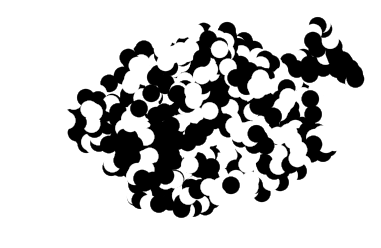

In [115]:
import matplotlib
matplotlib.use('TkAgg')
from pylab import *
import networkx as nx

##initialize
g = G_bus
g.pos = nx.spring_layout(g)
for i in g.nodes():
    g.node[i]['state'] = 1 if random() < .5 else 0
nextg = g.copy()

##observe
cla()
nx.draw(g, cmap = cm.binary, vmin = 0, vmax = 1,
       node_color = [g.node[i]['state'] for i in g.nodes()],
pos = g.pos)


##update
for i in g.nodes(): ##loop to sweep (buscar o barrer) the space
    count = g.node[i]['state'] ##variable count is first initialized with node i’s own state
    for j in g.neighbors(i): ## to sweep node i’s neighbors
        count += g.node[j]['state']
    ratio = count / (g.degree(i) + 1.0) #state ratio is calculated by dividing count by the number of nodes counted
    nextg.node[i]['state'] = 1 if ratio > .5 \
            else 0 if ratio < .5 \
            else 1 if random() < .5 else 0
g, nextg = nextg,g

For our particular network this first kind of simulation does not seem to give rise to any kind of conclusion, since what we are actually saying is that if the majority of the neighbours stations are not working, then the current  station i is likely to not working neither. 

## Discrete state/time models:

### Voter model

Each node (“voter”) takes one of the finite discrete states, but the up-dating rule is different. Instead of having all the nodes update their states simultaneously based on local majority choices, the voter model considers only one opinion transfer event at a time between a pair of connected nodes that are randomly chosen from the network.


There are three minor variations of how those nodes are chosen:

- **Original (“pull”) version:** First, a “listener” node is randomly chosen from the network, and then a “speaker” node is randomly chosen from the listener’s neighbors.

- ** Reversed (“push”) version:** First, a “speaker” node is randomly chosen from the network, and then a “listener” node is randomly chosen from the speaker’s neighbors.

- **Edge-based (symmetric) version:** First, an edge is randomly chosen from the network, and then the two endpoints (nodes) of the edge are randomly assigned to be a “speaker” and a “listener.”


Note that the first two assumptions are not symmetric regarding the probability for a node to be chosen as a “speaker” or a “listener.” The probability actually depends on how popular a node is. Specifically, the original version tends to choose higher-degree nodes as a speaker more often, while the reversed version tends to choose higher-degree nodes as a listener more often.

Therefore, it is expected that the **original** version of the voter model would promote **homogenization** of opinions as it gives more speaking time to the popular nodes, while the **reversed** version would give an equal chance of speech to everyone so the opinion **homogenization would be much slower**, and the edge-based version would be somewhere in between

Here is a sample code for the original “pull” version of the voter model:

/Users/gerardmartinezcanelles/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


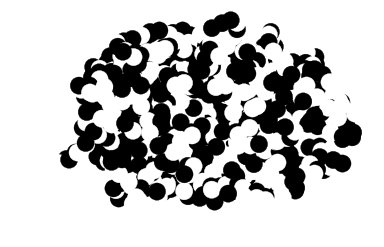

In [5]:
import matplotlib
matplotlib.use('TkAgg')
from pylab import *
import networkx as nx
import random as rd

##initialize():
g=G_bus
g.pos = nx.spring_layout(g)
for i in g.nodes():
    g.node[i]['state'] = 1 if random() < .5 else 0
    
## observe():

cla()
nx.draw(g, cmap = cm.binary, vmin = 0, vmax = 1,
    node_color = [g.node[i]['state'] for i in g.nodes()],
    pos = g.pos)

## update():
listener = rd.choice(list(g.nodes))
speaker = rd.choice(list(g.neighbors(listener)))
#speaker = rd.choice(list(g.neighbors(list(listener.values())[0])))
g.node[listener]['state'] = g.node[speaker]['state']

### Epidemic model 

#### Susceptible-Infected-Susceptible (SIS) model

In the SIS model, there are only two states: Susceptible and Infected. A susceptible node can get infected from an infected neighbor node with infection probability $p_{i}$ (per infected neighbor), while an infected node can recover back to a susceptible node (i.e., no immunity acquired) with recovery probability $p_{r}$.

![title](sisimage.png)

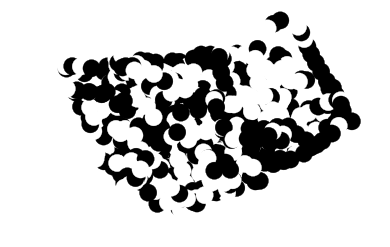

In [12]:
p_i = 0.5 # infection probability
p_r = 0.5 # recovery probability

g=G_bus
g.pos = nx.spring_layout(g)
for i in g.nodes():
    g.node[i]['state'] = 1 if random() < .5 else 0
    
## observe():

cla()
nx.draw(g, cmap = cm.binary, vmin = 0, vmax = 1,
    node_color = [g.node[i]['state'] for i in g.nodes()],
    pos = g.pos)


##update():
a = rd.choice(list(g.nodes()))
if g.node[a]['state'] == 0: # if susceptible
    b = rd.choice(g.neighbors(a))
    if g.node[b]['state'] == 1: # if neighbor b is infected
        g.node[a]['state'] = 1 if random() < p_i else 0 
    else: # if infected
        g.node[a]['state'] = 0 if random() < p_r else 1

##### Bus network probabilities

For our particular case, what it seems to be interesting is to determine the value of the 'infection' probability, understood as the the probability that a bus fails in a certain stop and see how this affects the rest of the network. It is well known that bus breakdowns can be modelled using a Poission distribution. This distribution gives the probability of the different possible number of occurrences of an event in a given time
interval under certain conditions. A Poisson distribution, is suitable to model:

• The events occur independently

• The events occur at random

• The probability of an event occurring in a given time interval does not vary with time.

We try to perform a research through TMB's website in order to know the number of accidents or breakdowns that occured 
during the last year and in this way fit a proper Poission ditribution. Unfortunately we did not find this kind of resource or similar. So we are going to simulate the computations. 


| Number of accidents per day | Frequency |
| ------------- |:-------------:|
| 0    | 395 | 
| 1    | 235     |  
| 2 | 73     | 
| 3 | 17    | 
| >3 | 0     | 

In this case, the given time interval is one day, or 24 hours. 

The total number of accidents has been $0 × 395 + 1 × 235 + 2 × 73 + 3 × 17 = 432 $

The number of days has been $395 + 235 + 73 + 17 = 720$

So the mean number of accidents per day has been $\frac{432}{720}=0.6$

The Poisson distribution is an example of a probability model. It is usually defined by the mean
number of occurrences in a time interval and this is denoted by $\lambda.$

The probability that there are r occurrences in a given interval is given by $P(X=r)=\frac{\lambda^{r}}{r!}e^{-\lambda}$.

In this example, $\lambda = 0.6$ and so the probabilities and expected frequencies in 720 days are as follows: 


|Number of accidents per day        | Probability (4 d.p.) (Prob per day)          | Expected frequency (1 d.p.)  |
| ------------- |:-------------:| -----:|
| 0     | 0.5488| 395.1 |
| 1      | 0.3293     |  237.1  |
| 2| 0.0988    |    71.1 |
| 3| 0.0197      |    14.2  |
| 4| 0.003      |    2.1|
| 5| 0.0004      |    0.3  |
| >5| 0      |    0 |


Another way to find probabilities is to use tables of Cumulative Poisson
probabilities. Note that in the following tables you are not given $P(X = r$) but $P(X \leq r)$.



|Number of accients per day        | Probability           | Number of accidents  | Probability |
| ------------- |:-------------:| --------:| -------:|
| 0     | 0.5488| 0 |  0.5488 |
| 0 or 1      | 0.8781     | 1 |  0.3293|
| 0,1, or 2| 0.9769    |    2 |  0.0988 |
| 0,1,2 or 3| 0.9966      |    3  |  0.0197 |
| 0,1,2,3 or 4| 0.9996      |    4|  0.003 |


The way we decided to determine the value of the 'infection' probability is to take the value of $Pr(X>0)=1-Pr(X \leq 0)=1-0.5488=0.45120$ which in fact captures the probability of the occurrence of one or more accidents. Since our network has 2469 nodes (or stations) the final value for the infection probability is set by:

$$P_{infection}=\frac{0.4512}{2469}=0.0001827460510328068$$

Hence we have captured the probability that at each step of the SIS model one station gets 'infected', or in other words, broken.

At the same time we increase the values of the recovery probability since the TMB infraestructure is well-coindition to perform recovery's of breakdowns in a very short time.
 

In [ ]:
from matplotlib import colors
import matplotlib.image as mpimg
from PIL import Image
import imageio


#p_i = 0.4512 # infection probability
p_i = 0.0001827460510328068 # infection probability
p_r = 0.95 # recovery probability

g=G_bus
g.pos = nx.spring_layout(g)
for i in g.nodes():
    g.node[i]['state'] = 1 if random() < .5 else 0 ## I have changed 0.5 per 0.01 I want the bus line to be 
                                                           ## fully operative
                                                        ## 0 means it works well  
                                                        ## 1 means failure
    ## observe():

cla()
nx.draw(g, cmap = colors.ListedColormap(['green', 'red']), vmin = 0, vmax = 1,
    node_color = [g.node[i]['state'] for i in g.nodes()],
    pos = g.pos)

##update():

#def plotNetwork(g):
#    nx.draw(g, cmap = colors.ListedColormap(['green', 'red']), vmin = 0, vmax = 1,
#        node_color = [g.node[i]['state'] for i in g.nodes()],
#        pos = g.pos)

#G=nx.grid_2d_graph(3,3) 
for i in range(1,1000):
    a = rd.choice(list(g.nodes()))
    if g.node[a]['state'] == 0: # if susceptible
        b = rd.choice(list(g.neighbors(a)))
        if g.node[b]['state'] == 1: # if neighbor b is infected
            g.node[a]['state'] = 1 if random() < p_i else 0 
    else: # if infected
        g.node[a]['state'] = 0 if random() < p_r else 1
    #plt.subplot(string)
    nx.draw(g, cmap = colors.ListedColormap(['#5adf16', 'red']), vmin = 0, vmax = 1,
        node_color = [g.node[i]['state'] for i in g.nodes()],
        pos = g.pos)
    #plt.savefig("sisplot/bus_sis_{i:}.jpg", format="PNG")
    plt.savefig('sisplot3/bus_sis'+str(i)+'.png')
    #plt.clf()
    #imageio.imwrite(f'sisplot/bus_sis_{i:}.jpg', plotdraw)
    #print([g.node[i]['state'] for i in g.nodes()])


KeyboardInterrupt: 

In order to build the GIF.

In [40]:
filenames=[]
for i in range(1,610):
    filenames.append('sisplot3/bus_sis'+str(i)+'.png')

In [41]:
import imageio
images = []
for filename in filenames:
    print(filename)
    images.append(imageio.imread(filename))
imageio.mimsave('sisplot3/moviedef.gif', images)

sisplot3/bus_sis1.png
sisplot3/bus_sis2.png
sisplot3/bus_sis3.png
sisplot3/bus_sis4.png
sisplot3/bus_sis5.png
sisplot3/bus_sis6.png
sisplot3/bus_sis7.png
sisplot3/bus_sis8.png
sisplot3/bus_sis9.png
sisplot3/bus_sis10.png
sisplot3/bus_sis11.png
sisplot3/bus_sis12.png
sisplot3/bus_sis13.png
sisplot3/bus_sis14.png
sisplot3/bus_sis15.png
sisplot3/bus_sis16.png
sisplot3/bus_sis17.png
sisplot3/bus_sis18.png
sisplot3/bus_sis19.png
sisplot3/bus_sis20.png
sisplot3/bus_sis21.png
sisplot3/bus_sis22.png
sisplot3/bus_sis23.png
sisplot3/bus_sis24.png
sisplot3/bus_sis25.png
sisplot3/bus_sis26.png
sisplot3/bus_sis27.png
sisplot3/bus_sis28.png
sisplot3/bus_sis29.png
sisplot3/bus_sis30.png
sisplot3/bus_sis31.png
sisplot3/bus_sis32.png
sisplot3/bus_sis33.png
sisplot3/bus_sis34.png
sisplot3/bus_sis35.png
sisplot3/bus_sis36.png
sisplot3/bus_sis37.png
sisplot3/bus_sis38.png
sisplot3/bus_sis39.png
sisplot3/bus_sis40.png
sisplot3/bus_sis41.png
sisplot3/bus_sis42.png
sisplot3/bus_sis43.png
sisplot3/bus_sis44.p

sisplot3/bus_sis362.png
sisplot3/bus_sis363.png
sisplot3/bus_sis364.png
sisplot3/bus_sis365.png
sisplot3/bus_sis366.png
sisplot3/bus_sis367.png
sisplot3/bus_sis368.png
sisplot3/bus_sis369.png
sisplot3/bus_sis370.png
sisplot3/bus_sis371.png
sisplot3/bus_sis372.png
sisplot3/bus_sis373.png
sisplot3/bus_sis374.png
sisplot3/bus_sis375.png
sisplot3/bus_sis376.png
sisplot3/bus_sis377.png
sisplot3/bus_sis378.png
sisplot3/bus_sis379.png
sisplot3/bus_sis380.png
sisplot3/bus_sis381.png
sisplot3/bus_sis382.png
sisplot3/bus_sis383.png
sisplot3/bus_sis384.png
sisplot3/bus_sis385.png
sisplot3/bus_sis386.png
sisplot3/bus_sis387.png
sisplot3/bus_sis388.png
sisplot3/bus_sis389.png
sisplot3/bus_sis390.png
sisplot3/bus_sis391.png
sisplot3/bus_sis392.png
sisplot3/bus_sis393.png
sisplot3/bus_sis394.png
sisplot3/bus_sis395.png
sisplot3/bus_sis396.png
sisplot3/bus_sis397.png
sisplot3/bus_sis398.png
sisplot3/bus_sis399.png
sisplot3/bus_sis400.png
sisplot3/bus_sis401.png
sisplot3/bus_sis402.png
sisplot3/bus_sis

In [44]:
import imageio
fps = 40
gif_original = 'sisplot3/moviedef.gif'
gif_speed_up = 'sisplot3/movie3speed.gif'

gif = imageio.mimread(gif_original,memtest=False)

imageio.mimsave(gif_speed_up, gif, fps=fps)

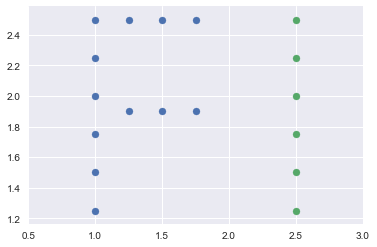

In [34]:
plt.plot()
plt.scatter([1,1,1,1,1,1,1.25,1.5,1.75,1.25,1.5,1.75],[1.25,1.5,1.75,2,2.25,2.5,2.5,2.5,2.5,1.9,1.9,1.9])
plt.scatter([2.5,2.5,2.5,2.5,2.5,2.5],[1.25,1.5,1.75,2,2.25,2.5])
plt.xlim(0.5,3)
plt.savefig('sisplot/bus_sis10000.png')
#plt.show()

## Continuous state/time models : 

### Diffusion model

Diffusion on a network can be a generalization of spatial diffusion models into non- regular, non-homogeneous spatial topologies. Each node represents a local site where some “stuff” can be accumulated, and each symmetric edge represents a channel through which the stuff can be transported, one way or the other, driven by the gradient of its con- centration.

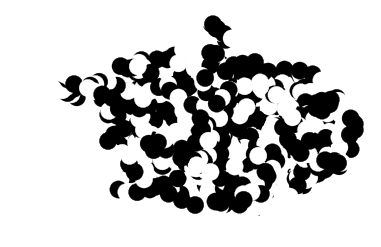

In [119]:
alpha = 1 # diffusion constant 
Dt = 0.01 # Delta t

##initialize
g = G_bus
g.pos = nx.spring_layout(g)
for i in g.nodes():
    g.node[i]['state'] = 1 if random() < .5 else 0
nextg = g.copy()

##observe
cla()
nx.draw(g, cmap = cm.binary, vmin = 0, vmax = 1,
       node_color = [g.node[i]['state'] for i in g.nodes()],
pos = g.pos)


## update():
for i in g.nodes():
    ci = g.node[i]['state']
    nextg.node[i]['state'] = ci + alpha * ( \
    sum(g.node[j]['state'] for j in g.neighbors(i)) \
    - ci * g.degree(i)) * Dt
    g, nextg = nextg, g

### Kuramoto Model

To represent this type of phase-based interaction among coupled oscillators, a Japanese physicist Yoshiki Kuramoto proposed the following very simple, elegant mathematical model in the 1970s

To read: https://arxiv.org/abs/1511.07139

In [ ]:
import matplotlib
matplotlib.use('TkAgg')
from pylab import *
import networkx as nx

def initialize():
    global g, nextg
    g = nx.karate_club_graph()
    g.pos = nx.spring_layout(g)
    for i in g.nodes_iter():
        g.node[i]['theta'] = 2 * pi * random()
        g.node[i]['omega'] = 1. + uniform(-0.05, 0.05)
    nextg = g.copy()
    
def observe():
    global g, nextg
    cla()
    nx.draw(g, cmap = cm.hsv, vmin = -1, vmax = 1,
            node_color = [sin(g.node[i]['theta']) for i in g.nodes_iter()],
            pos = g.pos)

alpha = 1 # coupling strength
Dt = 0.01 # Delta t

def update():
    global g, nextg
    for i in g.nodes_iter():
        theta_i = g.node[i]['theta']
        nextg.node[i]['theta'] = theta_i + (g.node[i]['omega'] + alpha * ( \
            sum(sin(g.node[j]['theta'] - theta_i) for j in g.neighbors(i)) \
            / g.degree(i))) * Dt
    g, nextg = nextg, g

/Users/gerardmartinezcanelles/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


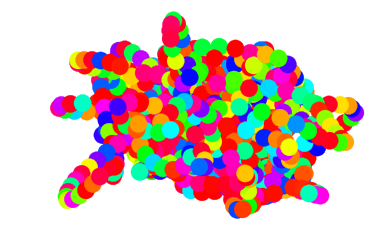

In [120]:
import matplotlib
matplotlib.use('TkAgg')
from pylab import *
import networkx as nx


#initialize
g = G_bus
g.pos = nx.spring_layout(g)
for i in g.nodes:
    g.node[i]['theta'] = 2 * pi * random()
    g.node[i]['omega'] = 1. + uniform(-0.05, 0.05)
nextg = g.copy()


##observe
PL.cla()
nx.draw(g, cmap = cm.hsv, vmin = -1, vmax = 1,
            node_color = [sin(g.node[i]['theta']) for i in g.nodes()],
            pos = g.pos)

alpha = 1 # coupling strength
Dt = 0.01 # Delta t

##update
for i in g.nodes():
    theta_i = g.node[i]['theta']
    nextg.node[i]['theta'] = theta_i + (g.node[i]['omega'] + alpha * ( \
        sum(sin(g.node[j]['theta'] - theta_i) for j in g.neighbors(i)) \
        / g.degree(i))) * Dt
g, nextg = nextg, g

## Simulating Dynamics of Networks

Dynamics of networks models capture completely different kinds of network dynamics, i.e., changes in network topologies. This includes the addition and removal of nodes and edges over time. 

Such dynamic changes of the system’s topology itself are quite unusual from a traditional dynamical systems viewpoint, because they would make it impossible to assume a well-defined static phase space of the system. But permitting such topological changes opens up a whole new set of possibilities to model various natural and social phenomena that were hard to capture in conventional dynamical systems frameworks, such as Growth of infrastructure networks (e.g., traffic networks, power grids, the Internet, WWW)

## Simulating Adaptive Networks


The final class of dynamical network models is that of adaptive networks. It is a hybrid of dynamics on and of networks, where states and topologies “co-evolve,” i.e., they interact with each other and keep changing, often over the same time scales.

**Adaptive epidemic model**

When you find out that one of your friends has caught a flu, you will probably not visit his or her room until he or she recovers from the illness. This means that human behavior, in response to the spread of illnesses, can change the topology of social ties, which in turn will influence the pathways of disease propagation.

When a susceptible node finds its neighbor is infected by the disease, it will sever the edge to the infected node with severance probability $p_{s}.$

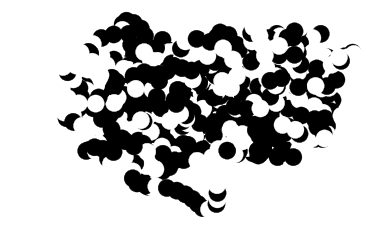

In [128]:
p_i = 0.5 # infection probability 
p_r = 0.5 # recovery probability
p_s = 0.5 # severance probability


g=G_bus
g.pos = nx.spring_layout(g)
for i in g.nodes():
    g.node[i]['state'] = 1 if random() < .5 else 0
    
## observe():

cla()
nx.draw(g, cmap = cm.binary, vmin = 0, vmax = 1,
    node_color = [g.node[i]['state'] for i in g.nodes()],
    pos = g.pos)



##update():
a = rd.choice(list(g.nodes()))
if g.node[a]['state'] == 0: # if susceptible
    if g.degree(a) > 0:
        b = rd.choice(g.neighbors(a))
        if g.node[b]['state'] == 1: # if neighbor b is infected 
            if random() < p_s:
                g.remove_edge(a, b)
            else:
                g.node[a]['state'] = 1 if random() < p_i else 0 
    else: # if infected
        g.node[a]['state'] = 0 if random() < p_r else 1

If we run this code, the result will probably look quite similar to the original SIS model, because the parameter settings used in this code (pi = pr = 0.5) don’t cause a pandemic. But if you try different parameter settings that would cause a pandemic in the original SIS model (say, pi = 0.5, pr = 0.2), the effect of the adaptive edge removal is much more salient.

Initially, the disease spreads throughout the network, but adaptive edge removal gradually removes edges from the network as an adaptive response to the pandemic, lowering the edge density and thus making it more and more difficult for the disease to spread. Eventually, the disease is eradicated when the edge density of the network hits a critical value below which the disease can no longer survive.

/Users/gerardmartinezcanelles/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


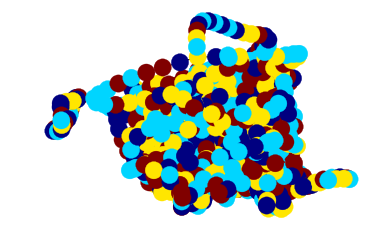

In [76]:
#import matplotlib
#matplotlib.use('qt4agg')

#import networkx as NX
#import random as RD
#import pylab as PL

#n = 100
#p = 0.1
#k = 4

##init
#g=G_bus
#g = NX.erdos_renyi_graph(n, p)
#for nd in g.nodes():
#    g.node[nd]['state'] = RD.choice(range(k))
#positions = NX.spring_layout(g)

##draw
#PL.cla()
#NX.draw(g, with_labels = False, pos = positions,
#        node_color = [g.node[n]['state'] for n in g.nodes()],
#        vmin = 0, vmax = k - 1, cmap = PL.cm.jet)
##step
#listener = RD.choice(g.nodes())
#if g.neighbors(list(listener.values())) != []:
#speaker = RD.choice(list(g.neighbors(list(listener.values())[0])))
#    #g.node[listener]['state'] = g.node[speaker]['state']

## Page Rank

In [27]:
pageRank = nx.pagerank(G_bus, alpha=0.9)

In [28]:
rank = sorted([pageRank[d] for d in pageRank], reverse=True)  
from scipy import stats
stats.describe(rank)

DescribeResult(nobs=2469, minmax=(0.00026609585969862646, 0.0012991301271914968), mean=0.0004050222762251924, variance=1.1050988772183222e-08, skewness=1.9868304519701934, kurtosis=5.862893302125078)

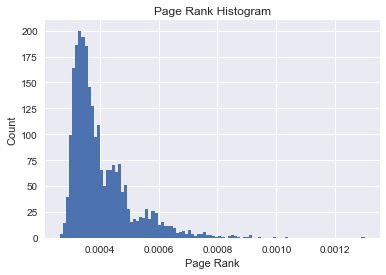

In [35]:
plt.title("Page Rank Histogram")
plt.ylabel("Count")
plt.xlabel("Page Rank")
plt.hist(rank,bins=100)
plt.show()

In [31]:
maxPageRank = max(pageRank.items(), key=operator.itemgetter(1))
maxPageRank

(777, 0.0012991301271914968)

In [32]:
bus_stations_properties[maxPageRank[0]]

{'id': '777',
 'street_name': 'Av de Roma-Tarragona',
 'city': 'BARCELONA',
 'utm_x': '428486,2180',
 'utm_y': '4581552,6000',
 'lat': '41.3805139',
 'lon': '2.1436483',
 'furniture': 'Pal',
 'buses': '30 - 32 - 43 - 44 - 78 - 115'}

### Conclusions

Using page rank computation, we obtain as "most important" node, the same as using degree centrality